<a href="https://colab.research.google.com/github/manmorjim/ai_playground/blob/main/somos_nlp/nlp_0_100/2_rnn_lstm/LSTM_NLP_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

## Descargamos el dataset

In [1]:
!wget https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv

--2023-06-04 15:31:48--  https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.1s    

2023-06-04 15:31:49 (43.8 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



## Importamos las librerías requeridas

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.12.0


## Visualizamos el dataset

In [4]:
df = pd.read_csv('bbc-text.csv')

In [ ]:
df.head()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [7]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## Creamos el dataset

In [32]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


## Definimos algunos parámetros de la red

In [9]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

## Dividimos del dataset

In [10]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


## Creamos el Tokenizador

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2432, 1, 225, 4996, 22, 641, 586, 225, 4996, 1, 1, 1662, 1, 1, 2432, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2308, 1, 1144, 1693, 1, 1720, 4997, 1, 1, 1, 1, 1, 4738, 1, 1, 122, 4515, 1, 2, 2875, 1505, 352, 4739, 1, 52, 341, 1, 352, 2172, 3963, 41, 22, 3794, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2367, 347, 4740, 1, 365, 22, 1, 787, 2368, 1, 4302, 138, 10, 1, 3665, 682, 3531, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4996, 1, 598, 1, 1693, 1021, 1, 4998, 808, 1863, 117, 1, 1, 1, 2975, 22, 1, 99, 278, 1, 1608, 4999, 542, 492, 1, 1445, 4741, 779, 1320, 1, 1860, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1506, 22, 479, 1, 1, 1665, 1, 797, 1, 3067, 1, 1364, 6, 1, 2432, 564, 22, 2972, 4735, 1, 1, 1, 1, 1, 850, 39, 1824, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1506, 1342, 374, 20, 63, 883, 1096, 4303, 247]


Añadimos padding, esto es añadir 0s para que todas las secuencias tengan el mismo tamaño. Las dimensiones de nuestra red neuronal es una fija, por tanto, todos los inputs de la red tienen que tener el mismo tamaño.
Para ello se usa el padding, las oraciones que usamos de input tienen tamaño distinto, es por ello que añadimos 0s (no aportan información) a esas oraciones más cortas:

In [14]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

425
200
192
200
186
200


In [15]:
print(train_padded[10])

[2432    1  225 4996   22  641  586  225 4996    1    1 1662    1    1
 2432   22  564    1    1  140  278    1  140  278  796  823  662 2308
    1 1144 1693    1 1720 4997    1    1    1    1    1 4738    1    1
  122 4515    1    2 2875 1505  352 4739    1   52  341    1  352 2172
 3963   41   22 3794    1    1    1    1  542    1    1    1  835  631
 2367  347 4740    1  365   22    1  787 2368    1 4302  138   10    1
 3665  682 3531    1   22    1  414  823  662    1   90   13  633    1
  225 4996    1  598    1 1693 1021    1 4998  808 1863  117    1    1
    1 2975   22    1   99  278    1 1608 4999  542  492    1 1445 4741
  779 1320    1 1860   10   33  641  319    1   62  478  564  301 1506
   22  479    1    1 1665    1  797    1 3067    1 1364    6    1 2432
  564   22 2972 4735    1    1    1    1    1  850   39 1824  675  297
   26  979    1  882   22  361   22   13  301 1506 1342  374   20   63
  883 1096 4303  247    0    0    0    0    0    0    0    0    0    0
    0 

In [16]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


## Codificamos las etiquetas usando el Tokenizador



In [17]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [18]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film en

## Construimos nuestra red neuronal

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim), # capa para hacer el embedding --> codifica los tokens a vectores de numeros
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), # LSTM
    tf.keras.layers.Dense(embedding_dim, activation='relu'), # capa para hacer RELU, si el valor es negativo pone 0 si no deja el mismo valor
    tf.keras.layers.Dense(6, activation='softmax') # la softmax interpreta los valores de RELU que viene siendo un numero a un valor entre 0 y 1 (probabilidad)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


Las dos capas Dense del final, realizan exactamente la clasificacion de las sentencias. Con la LSTM lo que hacemos es recoger toda la informacion posible de contexto de la oracion (almacenando la informacion en la memoria de la LSTM) y una vez que tenemos esa iformacion recopilada en un vector, lo pasamos por las capas Dense para clasificar y entrenar el modelo.
La softmax genera un unico numero a partir del vector para compararlo con la clasificacion esperada en el entrenamiento.

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [21]:
num_epochs = 3
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/3
56/56 - 21s - loss: 1.6026 - accuracy: 0.2815 - val_loss: 1.3857 - val_accuracy: 0.3685 - 21s/epoch - 368ms/step
Epoch 2/3
56/56 - 14s - loss: 1.1469 - accuracy: 0.5382 - val_loss: 0.7706 - val_accuracy: 0.7371 - 14s/epoch - 250ms/step
Epoch 3/3
56/56 - 23s - loss: 0.3389 - accuracy: 0.9107 - val_loss: 0.4366 - val_accuracy: 0.8539 - 23s/epoch - 412ms/step


## Visualizamos los resultados

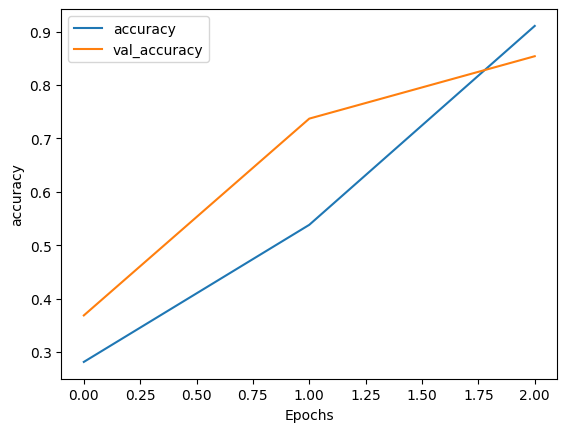

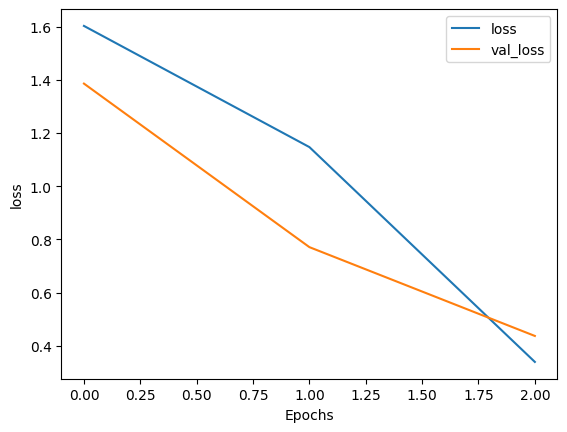

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [35]:
txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print('Predicción\n')
print(pred)
pred_label = np.argmax(pred)
print(pred_label)
#labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(txt[0] + ' => ' + labels[pred_label])

1/1 [==============================] - 0s 75ms/step
Predicción

[[0.00135192 0.30125925 0.07514926 0.01334711 0.00887771 0.60001475]]
5
Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report. => politics


## TODO: COMO OBTENGO EL LABEL PREDECIDO A PARTIR DEL NUMERO ??